# Проект  аналитика Яндекс.Афиши


## План работы:
1. [Загрузка данных и подготовка их к анализу](#load):
      - Проверка пропусков в данных
      - Проверка соотвествия типов данных
      - Общие сведения по таблицам
2. [Рассчет метрик и построение графиков](#step1):
      - [Продуктовые метрики](#products):
          - Рассчитать DAU, WAU и MAU. Вычислить средние значения этих метрик за весь период, а также построить график изменения метрик во времени;
          - Определить, сколько раз за день пользователи в среднем заходят на сайт. Выяснить, как изменяется эта метрика с течением времени;
          - Исследовать, сколько времени пользователи проводят на сайте. Посчитать среднюю продолжительность пользовательской сессии за весь период. Выясните, как продолжительность сессий распределена по пользователям;
          - Рассчитать Retention Rate, применяя когортный анализ.
      - [Метрики электронной коммерции](#ecomerce):
          - Исследуйте, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки
          - Применяя когортный анализ, рассчитайте среднее количество покупок на одного клиента за определённый период, например за 6 месяцев
          - Рассчитайте среднюю выручку с пользователя. Покажите, как меняется эта метрика с течением времени
          - Выясните, как меняется во времени накопительный LTV по когортам. Сравните средний LTV по когортам за 6 месяцев. Оценивайте когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%
      - [Маркетинговые метрики (Рассчитайте и отобразите на графиках, как маркетинговые метрики отличаются по рекламным источникам)](#marketing):
          - Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам и как меняется это распределение во времени
          - Рассчитайте CAC. Определите, сколько стоит привлечение одного покупателя из каждого источника трафика
          - Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт
3. [Выводы и рекомендации](#total)
    - Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции
    - Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

     

In [1]:
# импротируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import warnings
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 40)
warnings.filterwarnings("ignore")

In [2]:
# Для совместимости версий
!pip install plotly --upgrade --user
!pip install seaborn --upgrade --user

In [3]:
# открываем данные логов

#путь локальный
try:
    visits = pd.read_csv('data/visits_log.csv')
    cac_visits = pd.read_csv('data/visits_log.csv')
    orders = pd.read_csv('data/orders_log.csv')
    cac_orders = pd.read_csv('data/orders_log.csv')
    costs = pd.read_csv('data/costs.csv')
#путь практикума
except:
    visits = pd.read_csv('/datasets/visits_log.csv')
    orders = pd.read_csv('/datasets/orders_log.csv')
    cac_orders = pd.read_csv('/datasets/orders_log.csv')
    cac_visits = pd.read_csv('/datasets/visits_log.csv')
    costs = pd.read_csv('/datasets/costs.csv')

In [4]:
# переименуем стобцы для удобства
visits.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'],axis='columns', inplace=True)
cac_visits.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'],axis='columns', inplace=True)
orders.set_axis(['buy_ts', 'revenue', 'uid'], axis='columns', inplace = True)
cac_orders.set_axis(['buy_ts', 'revenue', 'uid'], axis='columns', inplace = True)

In [5]:
# изменим типы данных в колонках с датами на datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
cac_visits['start_ts'] = pd.to_datetime(cac_visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
cac_visits['end_ts'] = pd.to_datetime(cac_visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
cac_orders['buy_ts'] = pd.to_datetime(cac_orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

<a id="products"></a>

### Продуктовые метрики:
- Рассчитать DAU, WAU и MAU. Вычислить средние значения этих метрик за весь период, а также построить график изменения метрик во времени;
- Определить, сколько раз за день пользователи в среднем заходят на сайт. Выяснить, как изменяется эта метрика с течением времени;
- Исследовать, сколько времени пользователи проводят на сайте. Посчитать среднюю продолжительность пользовательской сессии за весь период. Выясните, как продолжительность сессий распределена по пользователям;
- Рассчитать Retention Rate, применяя когортный анализ.

In [6]:
visits['session_week'] = visits['start_ts'].dt.week
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_date'] = visits['start_ts'].dt.date
dau_data = visits.groupby('session_date').agg({'uid':'nunique'})
wau_data = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau_data = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

dau_total = int(dau_data.mean())
mau_total = int(mau_data.mean())
wau_total = int(wau_data.mean())

print('Daily active users равен: ',dau_total)
print('Weekly active users равен: ', wau_total)
print('Monthly active users равен: ', mau_total)
print('sticky mau factor:', dau_total/mau_total * 100)
print('sticky wau factor:', dau_total/wau_total * 100)

dau_data = dau_data.reset_index()
wau_data = wau_data.reset_index()
mau_data = mau_data.reset_index()

display(px.line(dau_data, x = 'session_date', y = 'uid', title = 'DAU за весь период'))
display(px.bar(wau_data, x = 'session_week', y = 'uid', title = 'WAU за весь период'))
display(px.bar(mau_data, x = 'session_month', y = 'uid', title = 'MAU за весь период'))

Daily active users равен:  907
Weekly active users равен:  5716
Monthly active users равен:  23228
sticky mau factor: 3.9047701050456345
sticky wau factor: 15.867739678096571


#### выводы графиков предыдущей ячейки для git
<img src="https://i.ibb.co/BzdgSDf/newplot-46.png">
<img src="https://i.ibb.co/ZHhPN5y/newplot-47.png">
<img src="https://i.ibb.co/TmL8rHp/newplot-48.png">

In [7]:
count_sessions = visits.groupby('session_date').agg({'uid':['count','nunique']})
count_sessions.columns = ['n_sessions', 'n_users']
count_sessions['session_per_user'] = count_sessions['n_sessions'] / count_sessions['n_users']
count_sessions = count_sessions.reset_index()
display(px.line(count_sessions, x = 'session_date', y = 'session_per_user', title = 'Изменение метрики заходов пользователей на сайт в день в течении времени'))
costs

source_id         dt  costs
0             1 2017-06-01  75.20
1             1 2017-06-02  62.25
2             1 2017-06-03  36.53
3             1 2017-06-04  55.00
4             1 2017-06-05  57.08
...         ...        ...    ...
2537         10 2018-05-27   9.92
2538         10 2018-05-28  21.26
2539         10 2018-05-29  11.32
2540         10 2018-05-30  33.15
2541         10 2018-05-31  17.60

[2542 rows x 3 columns]

#### выводы графиков предыдущей ячейки для git

<img src="https://i.ibb.co/YTBmD27/newplot-49.png">

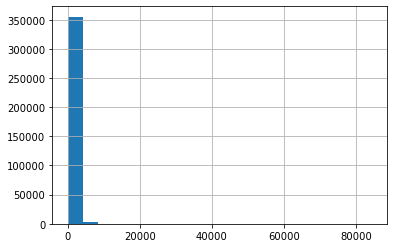

Средняя продолжительность сессии на сайте Афишы 643.506488592098
AverageSessionLength при не нормальном распределении(мода) 60


In [8]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins=20) # не похоже на нормальное расперделение
plt.show()
print('Средняя продолжительность сессии на сайте Афишы', visits['session_duration_sec'].mean())
ASL = visits['session_duration_sec'].mode()
print('AverageSessionLength при не нормальном распределении(мода)', int(ASL))

In [9]:
first_session_date = visits.groupby(['uid'])['session_date'].min()
first_session_date.name = 'first_activity_date'

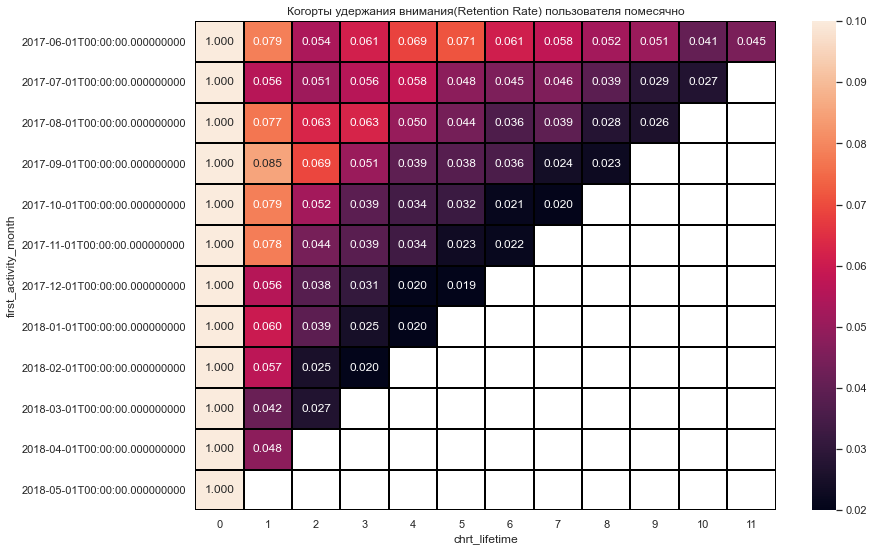

In [10]:
new_visits = visits.join(first_session_date, on = 'uid')
new_visits['session_date'] = pd.to_datetime(new_visits['session_date'])
new_visits['first_activity_date'] = pd.to_datetime(new_visits['first_activity_date'])
new_visits['activity_month'] = new_visits['session_date'].astype('datetime64[M]')
new_visits['first_activity_month'] = new_visits['first_activity_date'].astype('datetime64[M]')
new_visits['chrt_lifetime']  = new_visits['activity_month'] - new_visits['first_activity_month']
new_visits['chrt_lifetime'] = new_visits['chrt_lifetime'] / np.timedelta64(1, 'M') 
new_visits['chrt_lifetime'] = new_visits['chrt_lifetime'].round().astype('int')
chrt = new_visits.groupby(['first_activity_month','chrt_lifetime']).agg({'uid':'nunique'}).reset_index()

# какое количесвто пользователей было изначально в 0 когорте?
inital_users_cnt = chrt[chrt['chrt_lifetime'] == 0][['first_activity_month', 'uid']]
inital_users_cnt = inital_users_cnt.rename(columns = {'uid':'chrt_users'})
chrt = chrt.merge(inital_users_cnt, on = 'first_activity_month')
chrt['retention'] = chrt['uid'] / chrt ['chrt_users']
retention_pivot = chrt.pivot_table(index = 'first_activity_month',
                                    columns = 'chrt_lifetime',
                                    values= 'retention', aggfunc = 'sum')

sns.set(style='white')
plt.figure(figsize = (13,9))
plt.title('Когорты удержания внимания(Retention Rate) пользователя помесячно')
sns.heatmap(retention_pivot,
            annot = True,
           fmt = '.3f',
           linewidths = 1,
           linecolor = 'black' , vmin = .02 , vmax = .1)
plt.show()


## Выводы после расчетов продуктовых метрик:
1. 
            Daily active users равен:  907
            Weekly active users равен:  5716
            Monthly active users равен:  23228
            sticky mau factor: 3.9047701050456345
            sticky wau factor: 15.867739678096571
  После расчета DAU MAU WAU, были построены графики количества уникальных пользователей за весь период.
  Факторы прилипания в месяц и в неделю выглядят не плохо. Судя по графикам DAU во всем периоде, наибольшее количество пользователей уникальных с октября по март, видимо в этот период наибольшее количество событий афишируется в среднем в день это 907 пользователей. График по  MAU и WAU показывают что наименьший спрос у пользователей вызывает сайт афиша в июне. июле и августе.
2. Были подсчитаны количества сессий в день и построен график как изменялась метрика в течение всего периода, видно что сайт Афиша используют люди 1 раз в день в среднем не более. 
3. ASL показывает что пользователи в среднем проводят на сайте 1 минута.
4. Retention Rate для расчета показателя,в когортном анализе будем использовать период месяц. После построения heatmap по показателю retention можно сделать несколько выводов:
    - По отношению к нулевой когорте, во ВСЕХ месяцах наблюдается спад активности.
    - К третей когорте остается лишь половина пользователей от изначального количества
    - Наиболее удачная ситуация у польщователей чей первый визит был в июне. В течеение года осталась почти половина, что касается других месяцев то лишь 20% остается к завершению года.
    - Чем позже от июня пришел впервые пользователь тем меньше их останется в дальнейшем. Так что делаем ставки на Июнь :)

<a id="ecomerce"></a>

### Метрики электронной коммерции:


In [11]:
tmp_visits = new_visits[['source_id','uid', 'first_activity_date']]
first_orders = orders.groupby('uid')['buy_ts'].min()
first_orders.name = 'first_buy_date'
new_orders = orders.join(first_orders, on ='uid')




Среднее время от первого визита до первой покупки составляеят:  60120  секунд
В часах это около 16.7 часов


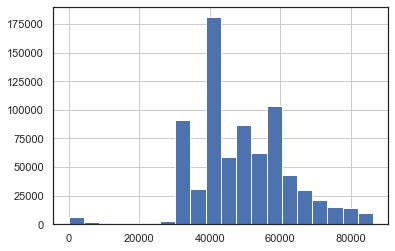

In [12]:
total_orders = tmp_visits.merge(new_orders, on = 'uid')
total_orders['sec_to_buy'] = (total_orders['first_buy_date'] - total_orders['first_activity_date']).dt.seconds
total_orders['sec_to_buy'].hist(bins=20)
mean_mode = int(total_orders['sec_to_buy'].mode())
print('Среднее время от первого визита до первой покупки составляеят: ',mean_mode , ' секунд')
print(f'В часах это около {mean_mode/60/60} часов')
# поскольку распределение не нормальное берем моду

#### Время от первого визита до первой покупки 60120 сек или 16.7 часов

In [13]:
# найдем количество покупателей в каждой когорте 
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
#total_orders['order_month'] = total_orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
#first_orders = total_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()

first_orders.columns = ['uid', 'first_order_month']
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'cnt_users']
new_orders = pd.merge(orders, first_orders, on='uid')
#new_orders = pd.merge(total_orders, first_orders, on='uid')

purchases_grouped_by_cohorts = new_orders.groupby(['first_order_month', 'order_month']).agg(
    {'revenue':'count',
    'uid':'nunique'})

purchases_grouped_by_cohorts['purchases_per_player'] = purchases_grouped_by_cohorts['revenue'] / purchases_grouped_by_cohorts['uid']
mean_purchases_pivot  = purchases_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                                 columns = 'order_month',
                                                                values = 'purchases_per_player', aggfunc='sum')

print('Среднее количесвто покупок за 6 месяцев', mean_purchases_pivot.cumsum(axis=1).mean(axis=1)[5])
display(mean_purchases_pivot)



Среднее количесвто покупок за 6 месяцев 6.238776212680655


order_month        2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
first_order_month                                                               
2017-06-01           1.163618    2.901639    3.480000    4.185185    3.318182   
2017-07-01                NaN    1.136765    1.923077    2.105263    1.625000   
2017-08-01                NaN         NaN    1.118978    1.862069    1.886792   
2017-09-01                NaN         NaN         NaN    1.136381    1.684615   
2017-10-01                NaN         NaN         NaN         NaN    1.143779   
2017-11-01                NaN         NaN         NaN         NaN         NaN   
2017-12-01                NaN         NaN         NaN         NaN         NaN   
2018-01-01                NaN         NaN         NaN         NaN         NaN   
2018-02-01                NaN         NaN         NaN         NaN         NaN   
2018-03-01                NaN         NaN         NaN         NaN         NaN   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   
2018-06-01                NaN         NaN         NaN         NaN         NaN   

order_month        2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
first_order_month                                                               
2017-06-01           3.253731    4.451613    3.702128    3.655172    3.400000   
2017-07-01           1.469388    2.157895    1.694444    1.282051    1.380952   
2017-08-01           1.840909    2.125000    1.937500    1.633333    1.772727   
2017-09-01           1.610000    2.216216    1.288462    1.703125    1.636364   
2017-10-01           1.524272    1.317073    1.326087    1.387097    1.430556   
2017-11-01           1.179368    1.788288    1.516667    1.990566    1.679012   
2017-12-01                NaN    1.152635    1.849315    1.961165    1.845361   
2018-01-01                NaN         NaN    1.121554    1.964912    1.915663   
2018-02-01                NaN         NaN         NaN    1.121611    1.881356   
2018-03-01                NaN         NaN         NaN         NaN    1.168978   
2018-04-01                NaN         NaN         NaN         NaN         NaN   
2018-05-01                NaN         NaN         NaN         NaN         NaN   
2018-06-01                NaN         NaN         NaN         NaN         NaN   

order_month        2018-04-01  2018-05-01  2018-06-01  
first_order_month                                      
2017-06-01           2.133333    1.622642         NaN  
2017-07-01           1.090909    2.038462         NaN  
2017-08-01           2.421053    1.483871         NaN  
2017-09-01           1.513514    1.418605         NaN  
2017-10-01           1.535714    1.865672         NaN  
2017-11-01           1.229167    1.645161         NaN  
2017-12-01           1.720000    1.666667         NaN  
2018-01-01           1.488372    1.733333         NaN  
2018-02-01           1.431034    1.794872         NaN  
2018-03-01           1.977778    3.034483         NaN  
2018-04-01           1.096221    2.826087         NaN  
2018-05-01                NaN    1.087349         NaN  
2018-06-01                NaN         NaN         1.0

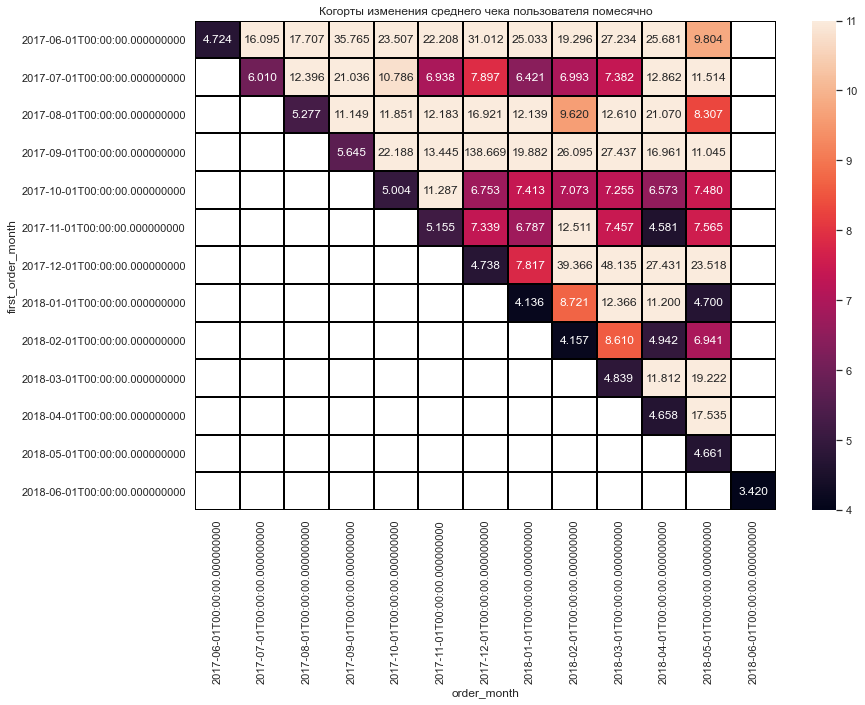

In [14]:
# средний чек
# для расчета среднего чека просумируем выручки и поделим на количесвто покупателей
group_by_chrt = new_orders.groupby(['first_order_month', 'order_month']).agg(
    {'revenue':'sum',
    'uid':'nunique'})
group_by_chrt['rev_per_uid'] =  group_by_chrt['revenue'] / group_by_chrt['uid']
mean_check_lifetime = group_by_chrt.pivot_table(index = 'first_order_month',
                                               columns = 'order_month',
                                               values = 'rev_per_uid', aggfunc = 'sum')

sns.set(style='white')
plt.figure(figsize = (13,9))
plt.title('Когорты изменения среднего чека пользователя помесячно')
sns.heatmap(mean_check_lifetime,
            annot = True,
           fmt = '.3f',
           linewidths = 1,
           linecolor = 'black' , vmin = 4 , vmax = 11)
plt.show()

Средняя сумма LTV покупателя когорты 2017-06-01  11.879233811171527
Средняя сумма LTV покупателя когорты 2017-07-01  8.386853874154951
Средняя сумма LTV покупателя когорты 2017-08-01  8.471722627737215
Средняя сумма LTV покупателя когорты 2017-09-01  13.435226656334766
Средняя сумма LTV покупателя когорты 2017-10-01  6.360241935483842
Средняя сумма LTV покупателя когорты 2017-11-01  6.3952438127909375
Средняя сумма LTV покупателя когорты 2017-12-01  7.639913301391703
Средняя сумма LTV покупателя когорты 2018-01-01  4.940151200711524
Средняя сумма LTV покупателя когорты 2018-02-01  4.587921117502053
Средняя сумма LTV покупателя когорты 2018-03-01  5.455253325785436
Средняя сумма LTV покупателя когорты 2018-04-01  5.189195957820724
Средняя сумма LTV покупателя когорты 2018-05-01  4.660562248995972
Средняя сумма LTV покупателя когорты 2018-06-01  3.42


age                      0         1         2         3         4         5   \
first_order_month                                                               
2017-06-01         4.724414  0.485329  0.437637  0.954671  1.022531  0.735502   
2017-07-01         6.010218  0.335211  0.623531  0.358976  0.176791  0.156048   
2017-08-01         5.276518  0.471993  0.458482  0.391277  0.494051  0.283540   
2017-09-01         5.644529  1.117586  0.520930  3.975792  0.400558  0.647067   
2017-10-01         5.003733  0.535763  0.191394  0.157145  0.151560  0.120362   
2017-11-01         5.154683  0.399233  0.199556  0.324952  0.148013  0.053879   
2017-12-01         4.738191  0.260374  0.925097  1.065275  0.312930  0.338047   
2018-01-01         4.135636  0.294758  0.304281  0.142778  0.062698       NaN   
2018-02-01         4.156987  0.278274  0.078515  0.074144       NaN       NaN   
2018-03-01         4.838803  0.300892  0.315559       NaN       NaN       NaN   
2018-04-01         4.657597  0.531599       NaN       NaN       NaN       NaN   
2018-05-01         4.660562       NaN       NaN       NaN       NaN       NaN   
2018-06-01         3.420000       NaN       NaN       NaN       NaN       NaN   

age                      6         7         8         9         10        11  
first_order_month                                                              
2017-06-01         0.950440  0.581592  0.553213  0.605788  0.571261  0.256856  
2017-07-01         0.120208  0.141820  0.161232  0.147145  0.155673       NaN  
2017-08-01         0.210664  0.405007  0.292212  0.187978       NaN       NaN  
2017-09-01         0.701608  0.243150  0.184006       NaN       NaN       NaN  
2017-10-01         0.084816  0.115470       NaN       NaN       NaN       NaN  
2017-11-01         0.114928       NaN       NaN       NaN       NaN       NaN  
2017-12-01              NaN       NaN       NaN       NaN       NaN       NaN  
2018-01-01              NaN       NaN       NaN       NaN       NaN       NaN  
2018-02-01              NaN       NaN       NaN       NaN       NaN       NaN  
2018-03-01              NaN       NaN       NaN       NaN       NaN       NaN  
2018-04-01              NaN       NaN       NaN       NaN       NaN       NaN  
2018-05-01              NaN       NaN       NaN       NaN       NaN       NaN  
2018-06-01              NaN       NaN       NaN       NaN       NaN       NaN

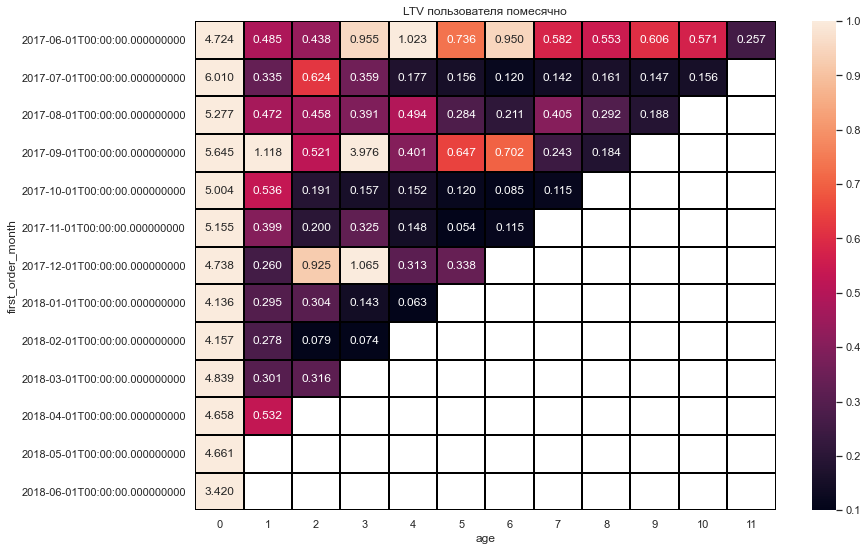

Средний LTV за 6 месяцев =  7.969052630207336


In [15]:
# LTV
cohorts = new_orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
margin_rate = 1.0

report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['gp'] / report['cnt_users']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
for x in output.index:
    print(f'Средняя сумма LTV покупателя когорты {x}'.split('00:')[0],output.loc[x].sum())


display(output)

sns.set(style='white')
plt.figure(figsize = (13,9))
plt.title('LTV пользователя помесячно')
sns.heatmap(output,
            annot = True,
           fmt = '.3f',
           linewidths = 1,
           linecolor = 'black' , vmin = .1 , vmax = 1)
plt.show()
print('Средний LTV за 6 месяцев = ',output.cumsum(axis=1).mean(axis=0)[5])

## Выводы после расчетов метрик электронной коммерци:
1. Среднее время от первого визита до первой покупки составляеят: 60120 сек или 16.7 часов
2. Изходя их среднего количество покупок каждого пользователя июньской когорты растет падает в середине а потом опять показывает рост и вновь падает в конце. Среднее количество покупок растет во всех пару месяцев(где то один), потом падает и вновь растет. **Среднее число покупок за 6 месяцев = 6.9**
3. Средний чек покупок пользователя от первой покупки к следующей как правило растет за исключением некоторых месяцев.
4. После расчета LTV на таблице видно что средний сумарный показатель ltv на пример в декабре составляет 4.7 а в сентября 11.25 - Сентябрь это лучшая когорта за 6 месяцев 2017 года. Июньская когорта  также показывает рост в сентябре. **Накопительный LTV за 6 месяцев = 7.96 покупки на одного покупателя**

<a id="marketing"></a>

## Маркетинговые метрики (Рассчитайте и отобразите на графиках, как маркетинговые метрики отличаются по рекламным источникам):
- Посчитайте общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам и как меняется это распределение во времени
- Рассчитайте CAC. Определите, сколько стоит привлечение одного покупателя из каждого источника трафика
- Рассчитайте ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт

In [16]:
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_costs = costs.groupby(['month','source_id']).sum()
monthly_costs = monthly_costs.reset_index()
costs_month_pivot = monthly_costs.pivot_table(index='month',
                                             columns = 'source_id',
                                             values = 'costs', aggfunc='sum')
for i in range(len(costs_month_pivot.columns)):
    print(f'Сумма затрат устройства source_id {costs_month_pivot.columns[i]} ->', costs_month_pivot[costs_month_pivot.columns[i]].sum())

display(px.line(monthly_costs, x = 'month', y = 'costs', color='source_id', title='Общие затраты по источникам трафика'))

Сумма затрат устройства source_id 1 -> 20833.269999999997
Сумма затрат устройства source_id 2 -> 42806.04
Сумма затрат устройства source_id 3 -> 141321.63
Сумма затрат устройства source_id 4 -> 61073.59999999999
Сумма затрат устройства source_id 5 -> 51757.1
Сумма затрат устройства source_id 9 -> 5517.49
Сумма затрат устройства source_id 10 -> 5822.49


#### вывод графика с предыдущей ячейки для git

<img src="https://i.ibb.co/cYv29pM/newplot-50.png">

In [17]:
cac_visits = cac_visits.sort_values(by = 'start_ts')
display(cac_visits)

device              end_ts  source_id            start_ts  \
308527  desktop 2017-06-01 00:02:00          5 2017-06-01 00:01:00   
260646  desktop 2017-06-01 00:02:00          3 2017-06-01 00:02:00   
245715  desktop 2017-06-01 00:16:00          3 2017-06-01 00:02:00   
235930  desktop 2017-06-01 00:04:00          3 2017-06-01 00:04:00   
11727   desktop 2017-06-01 00:11:00          1 2017-06-01 00:09:00   
...         ...                 ...        ...                 ...   
299620  desktop 2018-06-01 00:04:00          4 2018-05-31 23:59:00   
198329  desktop 2018-06-01 00:11:00          3 2018-05-31 23:59:00   
269213    touch 2018-06-01 00:12:00         10 2018-05-31 23:59:00   
294423  desktop 2018-05-31 23:59:00          2 2018-05-31 23:59:00   
263781  desktop 2018-06-01 00:25:00          1 2018-05-31 23:59:00   

                         uid  
308527  13890188992670018146  
260646  16152015161748786004  
245715  16706502037388497502  
235930   8842918131297115663  
11727   10329302124590727494  
...                      ...  
299620     83872787173869366  
198329   3720373600909378583  
269213  10723414689244282024  
294423  10406407303624848652  
263781   4906562732540547408  

[359400 rows x 5 columns]

In [18]:
# преподготовка перед расчетом САС
cac_orders['date_buy'] = cac_orders['buy_ts'].dt.date

min_orders = cac_orders.groupby('uid').agg({'date_buy':'min'})
min_orders.columns = ['first_dt_buy']

total_orders = pd.merge(cac_orders, min_orders, on = 'uid')
visit_source = pd.DataFrame(cac_visits.groupby('uid')['source_id'].first())
visit_order = pd.merge(total_orders, visit_source, on = 'uid')
grouped_by_source = visit_order.groupby(['source_id', 'first_dt_buy']).agg({'uid':'nunique'}).reset_index()
grouped_by_source.columns = ['source_id', 'dt', 'n_buyers']
grouped_by_source['dt'] = pd.to_datetime(grouped_by_source['dt'])


In [19]:
grouped_by_source

source_id         dt  n_buyers
0             1 2017-06-01        14
1             1 2017-06-02         7
2             1 2017-06-03         7
3             1 2017-06-04         3
4             1 2017-06-05        18
...         ...        ...       ...
2430         10 2018-05-27         2
2431         10 2018-05-28        10
2432         10 2018-05-29         7
2433         10 2018-05-30         5
2434         10 2018-05-31        35

[2435 rows x 3 columns]

In [20]:
# считаем САС
costs_grbsrc = grouped_by_source.merge(costs, on = ['dt', 'source_id'])
costs_grbsrc['cac'] = costs_grbsrc['costs'] / costs_grbsrc['n_buyers']


cac_pivot = costs_grbsrc.pivot_table(index = 'dt',
                                    columns = 'source_id',
                                    values = 'cac', aggfunc='mean')

print('CAC сводная по дням')
display(cac_pivot)

display(px.line(costs_grbsrc, x = 'dt', y = 'cac', color = 'source_id',title = 'CAC версия по датам(дням)'))

display(px.line(costs_grbsrc.groupby(['month','source_id'])['cac'].mean().reset_index(), x = 'month', y = 'cac', color = 'source_id',title = 'CAC (по месяцам)'))

print('проверка значений как должно быть -> round(costs["costs"].sum() / orders["uid"].nunique(), 2) -> ',round(costs['costs'].sum() / orders['uid'].nunique(), 2))

print('проверка значений Мой вариант источник 1  -> ', round(costs_grbsrc[costs_grbsrc['source_id'] == 1]['costs'].sum()/ costs_grbsrc[costs_grbsrc['source_id'] == 1]['n_buyers'].sum(), 2))
print('Выглядит верно. Так как в моей таблице costs_grbsrc уже посчитаны уникальные пользователи поэтому их просто суммируем')


CAC сводная по дням


source_id          1          2          3          4          5          9   \
dt                                                                             
2017-06-01   5.371429  12.050909  10.587273   7.674000   5.633846   3.265000   
2017-06-02   8.892857  13.238000  12.085385   2.041724   7.283529   3.626000   
2017-06-03   5.218571   9.650000  13.074667   4.949167   9.275714   7.060000   
2017-06-04  18.333333   7.908000  20.519474  17.996667   7.538571   1.162500   
2017-06-05   3.171111   6.810000   7.717636   2.126190   8.488235   2.185714   
...               ...        ...        ...        ...        ...        ...   
2018-05-27  15.445000  14.168750  11.082609   1.402000   9.406667  11.110000   
2018-05-28   5.447000   9.185556   6.524211   2.375172   4.250645   6.235000   
2018-05-29   5.557273   8.134615   9.147105   3.993846   5.123333   2.805000   
2018-05-30  13.047000   6.276842  13.299565   0.529706   8.225333  11.785000   
2018-05-31   3.542500   1.435876   7.088793   6.006585  10.757838   5.474000   

source_id          10  
dt                     
2017-06-01  15.080000  
2017-06-02   3.726667  
2017-06-03   1.374286  
2017-06-04   5.940000  
2017-06-05   3.811429  
...               ...  
2018-05-27   4.960000  
2018-05-28   2.126000  
2018-05-29   1.617143  
2018-05-30   6.630000  
2018-05-31   0.502857  

[363 rows x 7 columns]

проверка значений как должно быть -> round(costs["costs"].sum() / orders["uid"].nunique(), 2) ->  9.01
проверка значений Мой вариант источник 1  ->  7.17
Выглядит верно. Так как в моей таблице costs_grbsrc уже посчитаны уникальные пользователи поэтому их просто суммируем


In [21]:

clean_orders = cac_orders.drop('date_buy', axis = 1)
clean_orders['order_month'] = clean_orders['buy_ts'].astype('datetime64[M]')
first_clean_orders = clean_orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_clean_orders.columns = ['uid', 'first_order_month']
clean_orders = pd.merge(clean_orders, first_clean_orders, on = 'uid')
visit_and_orders = pd.merge(clean_orders,cac_visits, on = 'uid')


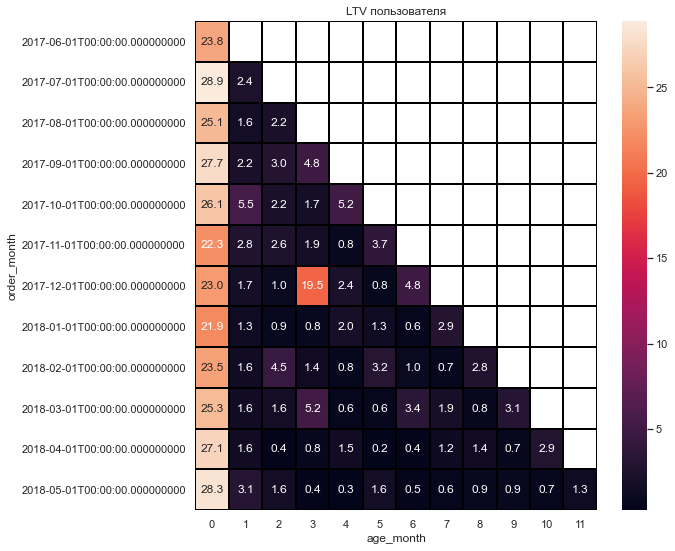

Средний LTV за 6 месяцев:  0.008795364729021067


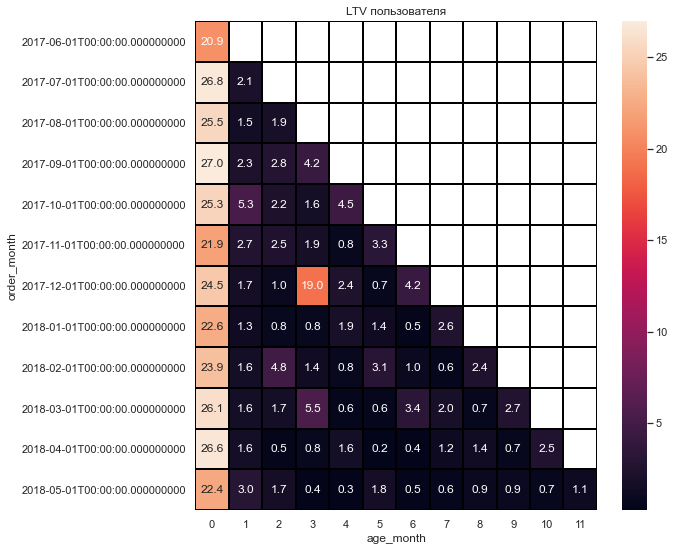

Средний LTV за 6 месяцев:  0.008507201163925966


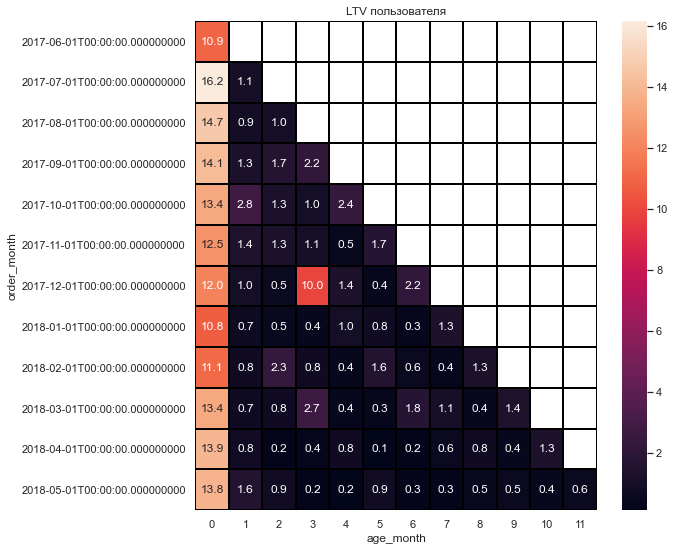

Средний LTV за 6 месяцев:  0.0045390571307280395


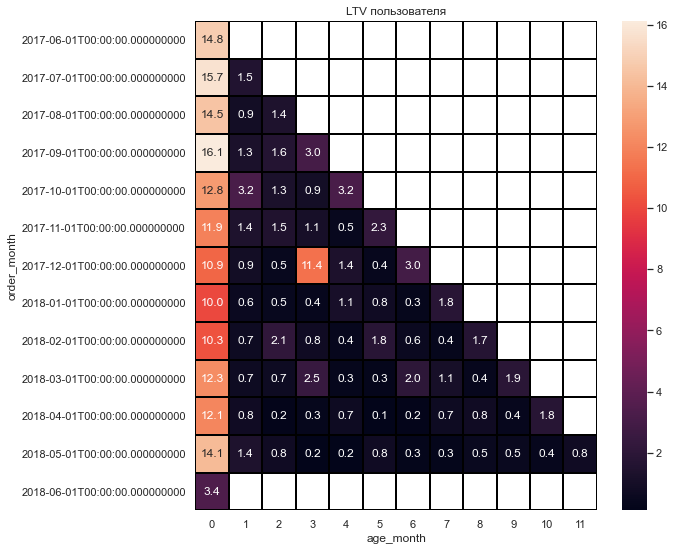

Средний LTV за 6 месяцев:  0.004717736944979239


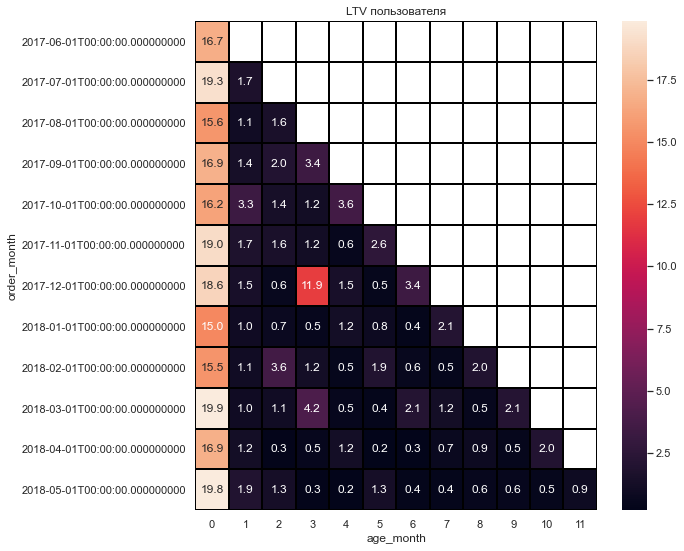

Средний LTV за 6 месяцев:  0.006041662419675738


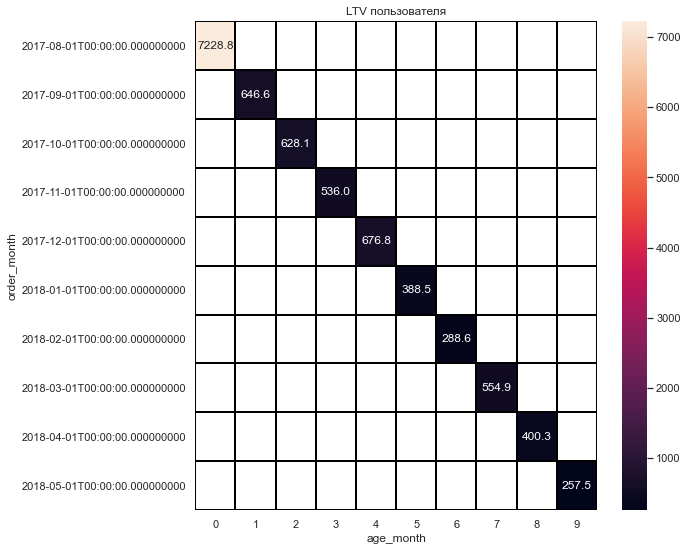

Средний LTV за 6 месяцев:  5.304506398537475


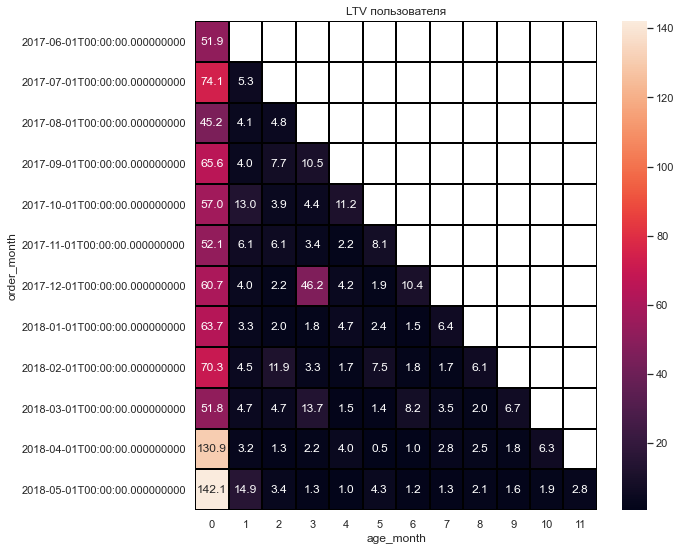

Средний LTV за 6 месяцев:  0.02375615277919749


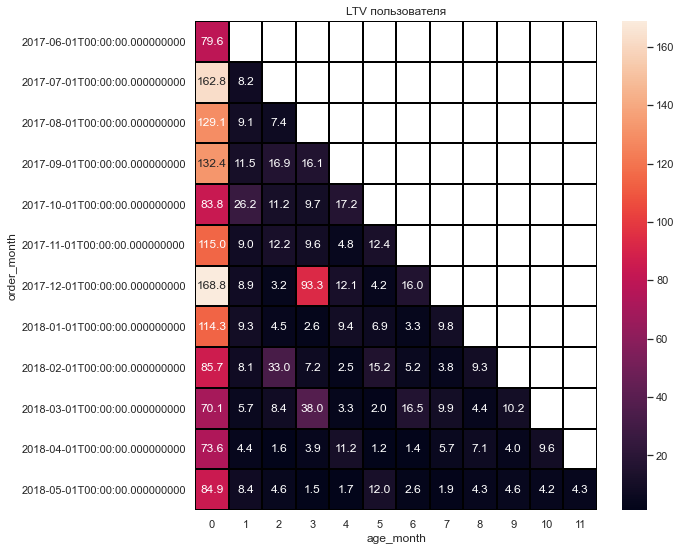

Средний LTV за 6 месяцев:  0.03864972737847554
{1: 0.008795364729021067, 2: 0.008507201163925966, 3: 0.0045390571307280395, 4: 0.004717736944979239, 5: 0.006041662419675738, 7: 5.304506398537475, 9: 0.02375615277919749, 10: 0.03864972737847554}


In [22]:
ltv = {}
for source, df in visit_and_orders.groupby('source_id'):
    
    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)
    
    cohorts = pd.merge(clean_orders, first_clean_orders, on = ['uid', 'first_order_month'])
    
    cohorts['age_month'] = (cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')
    cohorts['age_month'] = cohorts['age_month'].round().astype('int')
    #cohorts = cohorts.drop('buy_ts', axis = 1)
    #cohorts.columns = ['first_order_month', 'order_month', 'revenue', 'n_orders', 'age_month']
    cohorts_report = pd.merge(cohort_sizes,cohorts, on = 'first_order_month')
    cohorts_report['rev_per_buyer'] = cohorts_report['revenue'] / cohorts_report['n_buyers']
    
    # Возростной когортный отчет, показывающий накопительную выручку на покупателя

    cohorts_age = cohorts_report.pivot_table(index = 'order_month',
                                            columns = 'age_month',
                                            values = 'rev_per_buyer', aggfunc = 'sum')

    sns.set(style='white')
    plt.figure(figsize = (9,9))
    plt.title('LTV пользователя')
    sns.heatmap(cohorts_age,
                annot = True,
               fmt = '.1f',
               linewidths = 1,
               linecolor = 'black')
    plt.show()


    try: # не в каждом источнике достаточно данных для построения когорты
        ltv[source] = cohorts_report['rev_per_buyer'].mean() * margin_rate
        print('Средний LTV за 6 месяцев: ', ltv[source])      
    except KeyError:
        pass
print(ltv)

In [23]:
costs_grbsrc['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

In [24]:
roi = {}

for source, df in visit_and_orders[visit_and_orders['source_id'].isin(ltv.keys())].groupby('source_id'):

    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.rename(columns={'uid': 'n_buyers'}, inplace=True)

    cohorts = pd.merge(clean_orders, first_clean_orders, on = ['uid', 'first_order_month'])


    cohorts['age_month'] = (cohorts['order_month'] - cohorts['first_order_month']) / np.timedelta64(1, 'M')
    cohorts['age_month'] = cohorts['age_month'].round().astype('int')

    cohorts_report = pd.merge(cohort_sizes,cohorts, on = 'first_order_month')
    
    if source in costs_grbsrc['source_id'].unique():
        cac = costs_grbsrc.groupby('source_id').agg({'cac': 'mean'})['cac'][source]
        cohorts_report['roi_per_buyer'] =  ltv[source] / cac


cohorts_report

first_order_month  n_buyers              buy_ts  revenue  \
0            2017-06-01       120 2017-06-01 00:10:00    17.00   
1            2017-06-01       120 2017-06-01 00:25:00     0.55   
2            2017-06-01       120 2017-06-01 00:27:00     0.37   
3            2017-06-01       120 2017-06-01 00:29:00     0.55   
4            2017-06-01       120 2017-06-01 07:58:00     0.37   
...                 ...       ...                 ...      ...   
50409        2018-05-01       164 2018-05-31 23:43:00     3.67   
50410        2018-05-01       164 2018-05-31 23:50:00     4.64   
50411        2018-05-01       164 2018-05-31 23:50:00     5.80   
50412        2018-05-01       164 2018-05-31 23:54:00     0.30   
50413        2018-05-01       164 2018-05-31 23:56:00     3.67   

                        uid order_month  age_month  roi_per_buyer  
0      10329302124590727494  2017-06-01          0       0.005896  
1      11627257723692907447  2017-06-01          0       0.005896  
2      17903680561304213844  2017-06-01          0       0.005896  
3      16109239769442553005  2017-06-01          0       0.005896  
4      14200605875248379450  2017-06-01          0       0.005896  
...                     ...         ...        ...            ...  
50409   1805512004303848280  2018-05-01          0       0.005896  
50410  12296626599487328624  2018-05-01          0       0.005896  
50411  11369640365507475976  2018-05-01          0       0.005896  
50412   1786462140797698849  2018-05-01          0       0.005896  
50413   3993697860786194247  2018-05-01          0       0.005896  

[50414 rows x 8 columns]

<a id="total"></a>

# Выводы и рекомендации

 1. Выводы после расчетов **Маркетинговых метрик**:
     - Наиболее удачно себя показывает когорта Июня, Сентября и Декабря 2017 года это отчетливо видно на тепловой карте ROMI метрики в остальные месяцы исследуемого периода картина не очень привлекательная и есть над чем работать. 
     - РЕКОМЕНДАЦИЯ: Стоить обратить внимание на SOURCE_ID 10,9 так как на него уходят меньшие затраты  и ROMI хороший покщаатель, возможно стоить влить в эти  каналы средства еще большие, а остальные использвать таким же образом и брать пример.
    <img src="https://i.ibb.co/K92vR8s/newplot-3.png" alt="newplot-2" border="0">

2. Выводы после расчетов метрик **Электронной коммерции**:
      - Среднее время от первого визита до первой покупки составляет 16 часов, что конечно долго, но с другой стороны это Афиша, человек сначала делает выбор потом совещается со своей половинкой например стоит ли покупать билеты на концерт. Так же нужно подобрать время удачное. Так что 16 часов уже не кажутся такими долгими. Однако это время не мешало бы сократить вдвое и стараться вызвать покупку быстрей различными маркетинговыми мероприятиями. Например сделать рассылку вновь прибывшему с подарком в письме которым он может вопользоваться только в ближайшие 2 часа ). Это может подтолкнуть к покупке :)
      - Среднее количество покупок не превышает 6.9 на сайте за 6 месяцев Афиши. Наиболее удачно себя показывает когорта Июня и Сентября. Рекомендую сделать акцент на привлечение людей в июле и сентября так как именно эти когорты дают больший результат.
      - Средний чек по ВСЕМ когоротам растет его график очень волатилен из месяца в месяц, надо искать способы это стабилизировать. Какие пока не знаю, но привлекать внимание к спонтанным покупкам необходимо или продавать доп услуги какие то. Билет на концерт + Яндекс такси со скидкой 5 процентов. Или каждый 10 билет скидка. Продавать билеты по подписке с выгодой. Есть над чем подумать.
      - После расчета LTV на таблице видно что средний сумарный показатель ltv на пример в декабре составляет 4.7 а в сентября 11.25 - Сентябрь это лучшая когорта за 6 месяцев 2017 года. Июньская когорта также показывает рост в сентябре. Накопительный LTV за 6 месяцев = 7.96 покупки на одного покупателя

3. Выводы послче расчетов **Продуктовых метрик**:
           Daily active users равен:  907
           Weekly active users равен:  5716
           Monthly active users равен:  23228
           sticky mau factor: 3.9047701050456345
           sticky wau factor: 15.867739678096571
    - После расчета DAU MAU WAU, были построены графики количества уникальных пользователей за весь период.
       Факторы прилипания в месяц и в неделю выглядят не плохо. Судя по графикам DAU во всем периоде, наибольшее количество пользователей уникальных с октября по март, видимо в этот период наибольшее количество событий афишируется в среднем в день это 907 пользователей. График по  MAU и WAU показывают что наименьший спрос у пользователей вызывает сайт афиша в июне. июле и августе.
     - Были подсчитаны количества сессий в день и построен график как изменялась метрика в течение всего периода, видно что сайт Афиша используют люди 1 раз в день в среднем не более.
     
     <img src="https://i.ibb.co/LPNSTGf/newplot.png" alt="newplot" border="0">
     
   - ASL показывает что пользователи в среднем проводят на сайте почти сутки, что очень странно, что им там делать столько времени. Возможно просто открыли и оставили вкладку в браузере и не закрывают - было бы логично я сам так делаю, открываю инетресную страницу и не закрываю ее периодически к ней вновь возвращаясь, могу обновить ее раз в день. Все становится очень логичным: Ползователи открыли афишу и не закрывают ее, а обновляют страницу раз в день ведь Афиша самом собой раз в день и обновляется, а на следующий день вновь открыли вкладку и обновили, чтобы увидеть события на сегодня. Поэтому и 1 сессия в день в среднем, так как больше то и не надо.
   - Retention Rate для расчета показателя,в когортном анализе будем использовать период месяц. После построения heatmap по показателю retention можно сделать несколько выводов:
        - По отношению к нулевой когорте, во ВСЕХ месяцах наблюдается спад активности.
        - К третей когорте остается лишь половина пользователей от изначального количества
        - Наиболее удачная ситуация у польщователей чей первый визит был в июне. В течеение года осталась почти половина, что касается других месяцев то лишь 20% остается к завершению года.
        - Чем позже от июня пришел впервые пользователь тем меньше их останется в дальнейшем. Так что делаем ставки на Июнь :)
        